In [1]:
import torch
import torch.utils.data
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN_ResNet50_FPN_Weights

import utils
import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
root_path = '/home/aghosh57/Kerner-Lab/exploration/all_dataset/'

In [3]:
class ParcelDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        with open(self.root+'data.txt') as f:
            lines = f.readlines()
            lines = [x.strip() for x in lines]
            lines = [x.split(',') for x in lines]

        # Create separate lists for image, mask, and geojson file paths
        img_path = []
        mask_path = []
        geojson_path = []

        for i in range(len(lines)):
            img_path.append(self.root+lines[i][0])
            mask_path.append(self.root+lines[i][1])
            geojson_path.append(self.root+lines[i][2])

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = img_path
        self.masks = mask_path

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = np.array(boxes, dtype=np.float32)

        labels = np.ones((num_objs,), dtype=np.int64)        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = np.zeros((num_objs,), dtype=np.int64)

        temptargets = {}
        temptargets["boxes"] = boxes
        temptargets["labels"] = labels
        temptargets["masks"] = masks
        temptargets["image_id"] = idx
        temptargets["area"] = area
        temptargets["iscrowd"] = iscrowd


        #Remove the entries with area 0
        target = {}
        target["boxes"] = []
        target["labels"] = []
        target["masks"] = []
        target["image_id"] = idx
        target["area"] = []
        target["iscrowd"] = []

        for i in range(len(temptargets["area"])):
            if temptargets["area"][i] != 0:
                target["boxes"].append(temptargets["boxes"][i])
                target["labels"].append(temptargets["labels"][i])
                target["masks"].append(temptargets["masks"][i])
                target["area"].append(temptargets["area"][i])
                target["iscrowd"].append(temptargets["iscrowd"][i])

        target["boxes"] = torch.as_tensor(np.array(target["boxes"], dtype=np.float32))
        target["labels"] = torch.as_tensor(np.array(target["labels"], dtype=np.int64))
        target["masks"] = torch.as_tensor(np.array(target["masks"], dtype=np.uint8))
        target["image_id"] = torch.as_tensor(target["image_id"])
        target["area"] = torch.as_tensor(np.array(target["area"], dtype=np.float32))
        target["iscrowd"] = torch.as_tensor(np.array(target["iscrowd"], dtype=np.int64))

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
dataset = ParcelDataset(root_path, get_transform(train=False))

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

In [8]:
model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [9]:
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [66]:
image, targets = dataset[6]

image = torch.as_tensor(image, dtype=torch.float32).to(device)

image

tensor([[[0.2902, 0.3137, 0.3137,  ..., 0.3137, 0.3412, 0.3412],
         [0.2627, 0.2706, 0.2706,  ..., 0.3333, 0.3412, 0.3412],
         [0.2510, 0.2471, 0.2471,  ..., 0.3216, 0.3412, 0.3412],
         ...,
         [0.2275, 0.2196, 0.2353,  ..., 0.5961, 0.5922, 0.5922],
         [0.2314, 0.2314, 0.2392,  ..., 0.6118, 0.6118, 0.6118],
         [0.2353, 0.2353, 0.2353,  ..., 0.5922, 0.6039, 0.6039]],

        [[0.3137, 0.3294, 0.3294,  ..., 0.2980, 0.3020, 0.3020],
         [0.2824, 0.2980, 0.2980,  ..., 0.3020, 0.3020, 0.3020],
         [0.2745, 0.2706, 0.2706,  ..., 0.3098, 0.3098, 0.3098],
         ...,
         [0.2784, 0.2745, 0.2706,  ..., 0.4667, 0.4627, 0.4627],
         [0.2863, 0.2784, 0.2667,  ..., 0.4588, 0.4627, 0.4627],
         [0.2667, 0.2745, 0.2706,  ..., 0.4471, 0.4510, 0.4510]],

        [[0.1882, 0.2118, 0.2118,  ..., 0.1608, 0.1804, 0.1804],
         [0.1608, 0.1843, 0.1843,  ..., 0.1608, 0.1765, 0.1765],
         [0.1412, 0.1608, 0.1608,  ..., 0.1647, 0.1686, 0.

In [67]:
with torch.no_grad():
    predictions = model([image])

# Convert the prediction to a cpu element
predictions = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in predictions]

In [68]:

# Keep the prediction only with a certain prediction score

print('Before NMS:', len(predictions[0]['boxes']))

keep = torchvision.ops.nms(predictions[0]['boxes'], predictions[0]['scores'], 0.8)

predictions[0]['boxes'] = predictions[0]['boxes'][keep]
predictions[0]['labels'] = predictions[0]['labels'][keep]
predictions[0]['masks'] = predictions[0]['masks'][keep]
predictions[0]['scores'] = predictions[0]['scores'][keep]

print(predictions[0]['scores'])

print('After NMS:', len(predictions[0]['boxes']))

#Drop the prediction with a score lower than 0.5

print('Before threshold:', len(predictions[0]['boxes']))

threshold = 0.6

keep = predictions[0]['scores'] > threshold

predictions[0]['boxes'] = predictions[0]['boxes'][keep]
predictions[0]['labels'] = predictions[0]['labels'][keep]
predictions[0]['masks'] = predictions[0]['masks'][keep]
predictions[0]['scores'] = predictions[0]['scores'][keep]

print(predictions[0]['scores'])

print('After threshold:', len(predictions[0]['boxes']))

Before NMS: 100
tensor([0.9821, 0.9769, 0.9590, 0.9393, 0.9136, 0.9058, 0.8441, 0.8070, 0.7793,
        0.7494, 0.7052, 0.6991, 0.6329, 0.6222, 0.5728, 0.5502, 0.5002, 0.4926,
        0.4909, 0.4703, 0.4650, 0.4550, 0.4439, 0.4306, 0.4257, 0.4226, 0.4220,
        0.4134, 0.4007, 0.3906, 0.3589, 0.3510, 0.3268, 0.3261, 0.3242, 0.3217,
        0.3198, 0.3193, 0.3096, 0.3009, 0.2869, 0.2756, 0.2617, 0.2587, 0.2572,
        0.2568, 0.2541, 0.2454, 0.2375, 0.2267, 0.2229, 0.2134, 0.2088, 0.2006,
        0.2000, 0.1932, 0.1842, 0.1812, 0.1807, 0.1789, 0.1767, 0.1758, 0.1714,
        0.1689, 0.1642, 0.1584, 0.1581, 0.1571, 0.1538, 0.1523, 0.1512, 0.1409,
        0.1407, 0.1405, 0.1373, 0.1370, 0.1337, 0.1335, 0.1291, 0.1282, 0.1246,
        0.1218, 0.1203, 0.1191, 0.1170, 0.1160, 0.1155, 0.1126, 0.1109, 0.1103,
        0.1079, 0.1072, 0.1066, 0.1047, 0.1022, 0.1012, 0.1009, 0.1007, 0.0999,
        0.0999])
After NMS: 100
Before threshold: 100
tensor([0.9821, 0.9769, 0.9590, 0.9393, 0.9136, 0.

In [69]:
len(targets['boxes'])

16

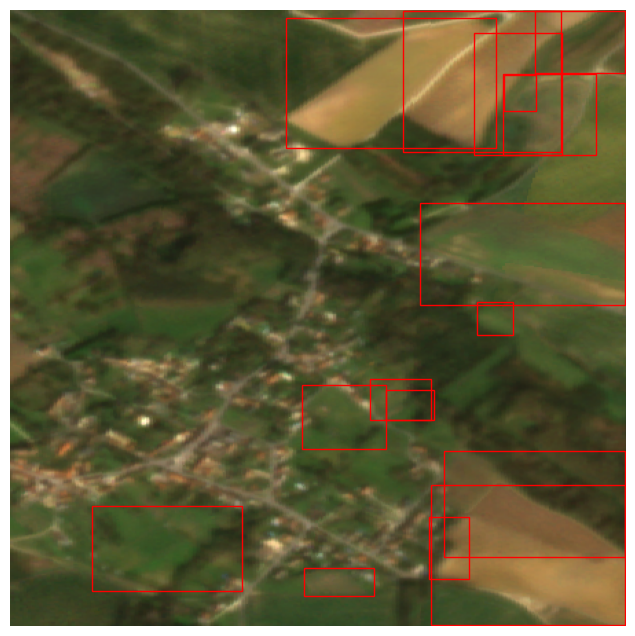

In [70]:
# plot the targets boxes on the image, plot the boxes

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.imshow(image.cpu().permute(1, 2, 0))
ax.axis('off')

for i in range (len(targets['boxes'])):
    xmin = targets['boxes'][i][0]
    ymin = targets['boxes'][i][1]
    xmax = targets['boxes'][i][2]
    ymax = targets['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()




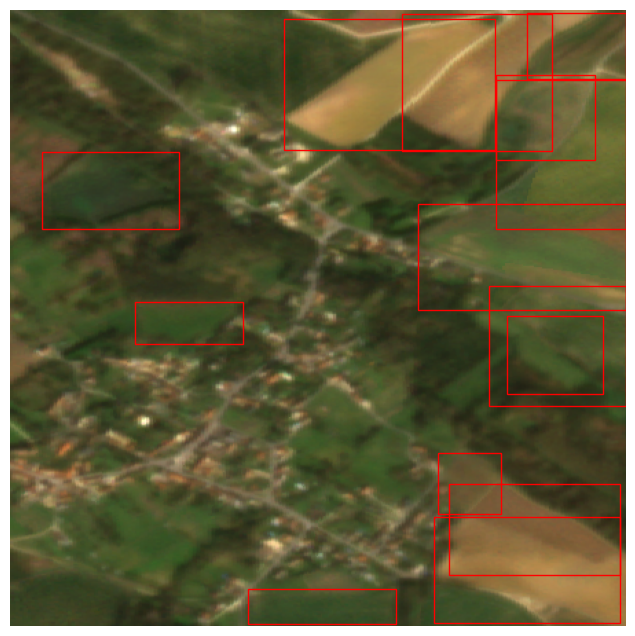

In [71]:
# Plot the predicted boxes on the image, plot the boxes

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.imshow(image.cpu().permute(1, 2, 0))
ax.axis('off')

for i in range (len(predictions[0]['boxes'])):
    xmin = predictions[0]['boxes'][i][0]
    ymin = predictions[0]['boxes'][i][1]
    xmax = predictions[0]['boxes'][i][2]
    ymax = predictions[0]['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()